# Tokenized Population Transformer Analysis

For analysis of run 15

In [1]:
## Import meta setup

# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

# Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [59]:
import os
from timeit import default_timer
import json
import collections
import itertools

from lib.params import device, use_cuda # device, use_cuda, Checkpoint, various saving strs
from lib.datasets import TokenizedPopDataset, TokenizedCollateFn, FilledMatrixDataset
from lib.models import TokenizedPopTransformer
from lib.saveload import *


import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from torch import nn


# Viz
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
# pio.renderers.default = "notebook+plotly_mimetype+png"
# For some reason, the correct setting to get the plots to show up in Quarto HTML?
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

from bertviz import head_view, model_view

## Load Data

### Source King and Label Data

In [7]:
datapath = "../Data/king_matrix.csv"

# The official 1000 genome sample names to popcodes
sample_to_popcode = pd.read_csv("../Data/igsr_samples.tsv", sep="\t")[["Sample name", "Population code", "Superpopulation code", "Superpopulation name"]].dropna()
sample_to_label = sample_to_popcode.set_index("Sample name").to_dict()["Population code"]
pop_to_superpop = sample_to_popcode.set_index("Population code").to_dict()["Superpopulation code"]
superpop_to_name = sample_to_popcode.set_index("Superpopulation code").to_dict()["Superpopulation name"]
pop_to_supername = sample_to_popcode.set_index("Population code").to_dict()["Superpopulation name"]

# Labels as descriptive names
label_names = pd.read_csv("../Output/Heritage_UMAP/umap_embeddings.csv").iloc[:, -1]
# Label int to popcode
king_popcodes = pd.read_csv("../Output/Heritage_UMAP/variable_to_integer_conversion_tribe_string_labels.csv", index_col=0)
# Labels as ints
y_ints = pd.read_csv("../Output/Heritage_UMAP/labels_file_series.csv", index_col=0)["0"]
# Labels as popcodes
label_codes = y_ints.replace(king_popcodes.set_index("0").to_dict()["1"])


# Labels as superpops
label_superpops = label_codes.replace(pop_to_superpop)
label_superpops_y = label_superpops.astype("category").cat.codes

king_matrix = pd.read_csv(datapath).fillna(0).to_numpy()
X = king_matrix

X_filled = FilledMatrixDataset(datapath, normalize=True).X.to_numpy()

print(label_names, label_codes, y_ints)
X

0       British\nEngland and Scotland
1       British\nEngland and Scotland
2       British\nEngland and Scotland
3       British\nEngland and Scotland
4       British\nEngland and Scotland
                    ...              
2498      Gujarati Indian\nHouston,TX
2499      Gujarati Indian\nHouston,TX
2500      Gujarati Indian\nHouston,TX
2501      Gujarati Indian\nHouston,TX
2502      Gujarati Indian\nHouston,TX
Name: Label, Length: 2503, dtype: object 0       GBR
1       GBR
2       GBR
3       GBR
4       GBR
       ... 
2498    GIH
2499    GIH
2500    GIH
2501    GIH
2502    GIH
Name: 0, Length: 2503, dtype: object 0       10
1       10
2       10
3       10
4       10
        ..
2498    11
2499    11
2500    11
2501    11
2502    11
Name: 0, Length: 2503, dtype: int64


array([[-0.0091, -0.0023, -0.0143, ..., -0.0278, -0.034 , -0.0348],
       [ 0.    , -0.0004,  0.0173, ..., -0.0066,  0.0074, -0.0152],
       [ 0.    ,  0.    ,  0.0147, ..., -0.0347, -0.0333, -0.0283],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.0187,  0.0126,  0.015 ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.0161, -0.0096],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.0181]])

### NN Input Dataset and Constructor

In [60]:
# From train 15
dsize = 20000
vstart = int(dsize * 0.8)
maxseqlen = 100
maxind = 2502

dataset = TokenizedPopDataset(datapath, y_ints, dsize=dsize, maxseqlen=maxseqlen, maxind=maxind)
dataset_superpop = TokenizedPopDataset(datapath, label_superpops_y, dsize=dsize, maxseqlen=maxseqlen, maxind=maxind)

# Don't need to random sample to make subsets since they're already random lens of random inds, and want even distribution
# of representative indices in both train/test
train, test = Subset(dataset, range(vstart)), Subset(dataset, range(vstart, dsize))
train_superpop, test_superpop = Subset(dataset_superpop, range(vstart)), Subset(dataset_superpop, range(vstart, dsize))

fn=TokenizedCollateFn(dataset.padind, dataset.padval).collate_fn
test_dataloader = DataLoader(test, batch_size=1, num_workers=1, shuffle=False, collate_fn=fn)

fn_superpop=TokenizedCollateFn(dataset_superpop.padind, dataset_superpop.padval).collate_fn
test_superpop_dataloader = DataLoader(test_superpop, batch_size=1, num_workers=1, shuffle=False, collate_fn=fn_superpop)



print(len(dataset), len(dataset[-1][0]), dataset[0][0].shape, dataset[0][1].shape)
print(len(train_superpop), len(train_superpop[0][0]), train_superpop[2501][0].shape, train_superpop[2501])

20000 3 torch.Size([2]) torch.Size([2])
16000 2 torch.Size([28]) (tensor([ 147, 1457,  367,  751, 1486, 2499, 1700,  762, 2068, 1403,  584,   50,
        1216, 1031,  567, 1279,  594,  195, 1650, 2437, 1154,   73,  485, 2071,
        1787, 1873, 1546,  611], dtype=torch.int32), tensor([3, 4, 1, 2, 4, 4, 3, 0, 0, 4, 3, 3, 0, 0, 3, 0, 3, 2, 4, 4, 0, 3, 1, 0,
        2, 2, 4, 3]))


In [14]:
def make_data(inds: list[int], targets):
    """ Assumes inds are a list of the original indices, with maxind <= maxind set in the model
    """
    x = torch.tensor(inds, dtype=torch.int32, device=device)[None, :]
    # target = F.pad(torch.tensor(X_filled[1:, :-1][inds, :][:, inds], device=device), (0, maxseqlen - len(inds)), value=padval)[None, :, :]
    target = torch.tensor(targets[x.numpy()[0, :]].to_numpy(), dtype=torch.long, device=device)[None, :]
    mask = torch.full(x.shape, True).to(device)
    mask[:, :len(inds)] = False
    return x, target, mask

# Example
x, target, mask = make_data([1, 2, 4], y_ints)
print(x.shape, target.shape, mask.shape, x, target, mask)

torch.Size([1, 3]) torch.Size([1, 3]) torch.Size([1, 3]) tensor([[1, 2, 4]], dtype=torch.int32) tensor([[10, 10, 10]]) tensor([[False, False, False]])


## Load Model

In [18]:
runname = "test15"
model_names = ["Test_30_pop_2h", "Test_31_superpop_2h"]
machine = "Paperspace"
rundir = os.path.join("../Output/Runs/", runname)
outdir = rundir

print(f"Using {device} device")

with open(os.path.join(rundir, f"details_{runname}.json")) as file:
    params = json.load(file)
    params["Test_30_pop_2h"]["num_classes"] = 26
    params["Test_31_superpop_2h"]["num_classes"] = 5
    print(params)

models = []
for model_name in model_names:
    _, model_state = load_checkpoint(model_name, machine, rundir)
    params[model_name]["activation"] = eval(params[model_name]["activation"])()
    model = TokenizedPopTransformer(**params[model_name]).to(device)
    model.load_state_dict(model_state, strict=True)
    models.append(model)
    
print(models)

Using cpu device
{'run_params': {'machine': 'Paperspace', 'epochs': 80, 'checkpoint_at': 20, 'load': False, 'batch_pr': 80, 'runname': 'test15'}, 'Test_30_pop_2h': {'name': 'Test_30_pop_2h', 'num_classes': 26, 'd_model': 120, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'activation': 'nn.Tanh', 'use_pe': False, 'dropout_pe': 0.0, 'maxseqlen': 100, 'maxind': 2502, 'num_head': 2}, 'Test_31_superpop_2h': {'name': 'Test_31_superpop_2h', 'num_classes': 5, 'd_model': 120, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'activation': 'nn.Tanh', 'use_pe': False, 'dropout_pe': 0.0, 'maxseqlen': 100, 'maxind': 2502, 'num_head': 2}}
Found checkpoint to load. Using: Paperspace_Test_30_pop_2h_checkpoint_2024-12-06_123719.tar
Found model state dict to load. Using: Paperspace_Test_30_pop_2h_state-dict_2024-12-06_123719.pt
Found checkpoint to load. Using: Paperspace_Test_31_superpop_2h_checkpoint_2024-12-06_141835.tar
Found model state dict to loa

In [19]:
for i in models[0].encoder.layers[0].named_parameters():
    print(i, i[1].shape)

for i in models[0].embed.named_parameters():
    print(i, i[1].shape)

('self_attn.in_proj_weight', Parameter containing:
tensor([[-0.0299,  0.0499, -0.1589,  ..., -0.0250,  0.1679,  0.0582],
        [ 0.0497, -0.1075,  0.1107,  ..., -0.0210, -0.1790,  0.0023],
        [-0.0130, -0.1152,  0.0024,  ..., -0.0028, -0.0482, -0.1260],
        ...,
        [-0.0389,  0.0758,  0.0816,  ..., -0.1319,  0.0649,  0.0047],
        [-0.0034, -0.1334, -0.0298,  ...,  0.1047,  0.0454,  0.1888],
        [-0.0407, -0.1164, -0.1594,  ...,  0.0509, -0.0129,  0.0681]],
       requires_grad=True)) torch.Size([360, 120])
('self_attn.in_proj_bias', Parameter containing:
tensor([ 6.7908e-02, -3.9687e-03,  5.7344e-02,  8.0905e-02,  2.3138e-02,
         4.8253e-02,  1.4205e-02,  9.8790e-02,  7.1555e-02,  1.7659e-02,
        -1.8697e-03, -3.5169e-02,  1.1385e-01, -6.0449e-02,  1.6123e-01,
         5.7278e-02, -4.7631e-02,  2.6099e-02, -1.7835e-02,  6.0392e-03,
         1.4979e-01,  4.1899e-02,  8.5523e-02, -1.6399e-01, -2.0423e-02,
         2.0194e-02,  1.1458e-02, -7.4999e-02, -3.

### Model Output Hooks

In [44]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        if "attn" in name:
            activation[name] = list(x.detach() for x in output if x is not None)
        else:
            activation[name] = output.detach()
    return hook

def make_multi_head_output(module, args, kwargs):
    kwargs["average_attn_weights"] = False
    kwargs["need_weights"] = True
    return args, kwargs

def register_hooks(model):
    # register the forward hooks
    model.encoder.layers[-1].register_forward_hook(get_activation('ellast'))
    model.encoder.layers[-1].linear2.register_forward_hook(get_activation('ellast_lin2'))
    model.encoder.layers[-1].linear1.register_forward_hook(get_activation('ellast_lin1'))
    model.encoder.layers[0].self_attn.register_forward_hook(get_activation('el1_attn'))
    model.encoder.layers[1].self_attn.register_forward_hook(get_activation('el2_attn'))
    model.encoder.layers[2].self_attn.register_forward_hook(get_activation('el3_attn'))
    model.encoder.register_forward_hook(get_activation('encoder'))

    model.encoder.layers[0].self_attn.register_forward_pre_hook(make_multi_head_output, with_kwargs=True, prepend=True)
    model.encoder.layers[1].self_attn.register_forward_pre_hook(make_multi_head_output, with_kwargs=True, prepend=True)
    model.encoder.layers[2].self_attn.register_forward_pre_hook(make_multi_head_output, with_kwargs=True, prepend=True)

[register_hooks(m) for m in models]

[None, None]

#### Test

In [22]:
models[1].train(False)
models[1].eval()

# pass some data through the model
x, _, mask = make_data([1, 5, 10, 20], label_superpops_y)
out = models[1](x, mask)

print(activation["el1_attn"][0].shape, activation["el1_attn"][1].shape, activation["encoder"].shape)
# Output
activation

torch.Size([1, 4, 120]) torch.Size([1, 2, 4, 4]) torch.Size([1, 4, 120])


{'el1_attn': [tensor([[[-3.6802e-01, -4.2912e-01,  4.4451e-01, -6.9344e-01, -7.5654e-02,
            -1.1012e+00, -2.0267e-01, -3.1190e-01,  3.0617e-01,  1.0506e+00,
             3.5507e-01,  3.6460e-01,  2.1038e-01,  7.8221e-01,  7.7577e-01,
             8.0299e-01, -5.9122e-01,  3.5013e-01, -1.7967e-01,  3.4497e-01,
            -5.3554e-01, -4.7270e-01, -4.3997e-01, -1.1491e+00,  1.8743e-01,
             8.1403e-01, -3.7459e-01, -2.3895e-01,  3.9837e-01,  8.1955e-02,
             3.6943e-01, -5.9286e-01,  7.4579e-02,  3.7108e-02, -2.6539e-01,
             8.9401e-01, -9.0904e-01,  4.6155e-01,  1.1020e-01,  5.5638e-01,
            -7.0144e-01, -3.2748e-01, -3.0841e-01,  1.4742e-01,  3.6575e-01,
            -1.1901e-01, -1.3548e-01,  3.6466e-01,  3.8922e-01,  1.9359e-01,
             1.3268e-01,  2.0212e-01, -3.2913e-01,  1.2324e+00, -6.1315e-01,
            -5.9036e-01,  1.4454e-01,  2.3474e-01, -1.1131e-01, -6.1385e-02,
            -3.0504e-01, -3.2483e-01, -6.0900e-01,  1.4009e-01, 

## Embedding Analysis

(2503, 120)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

python3.10(35314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


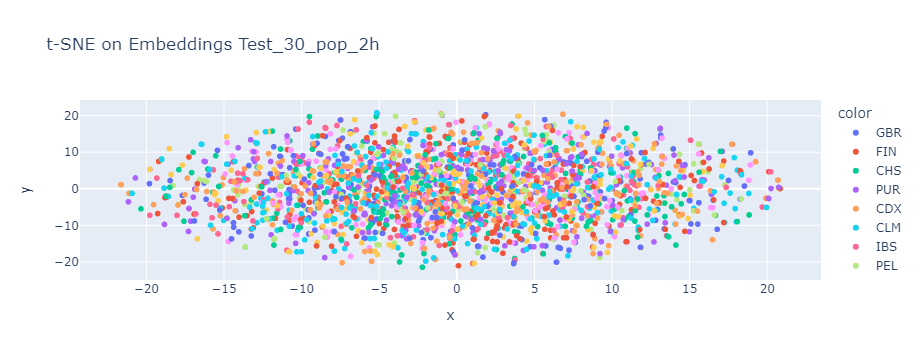

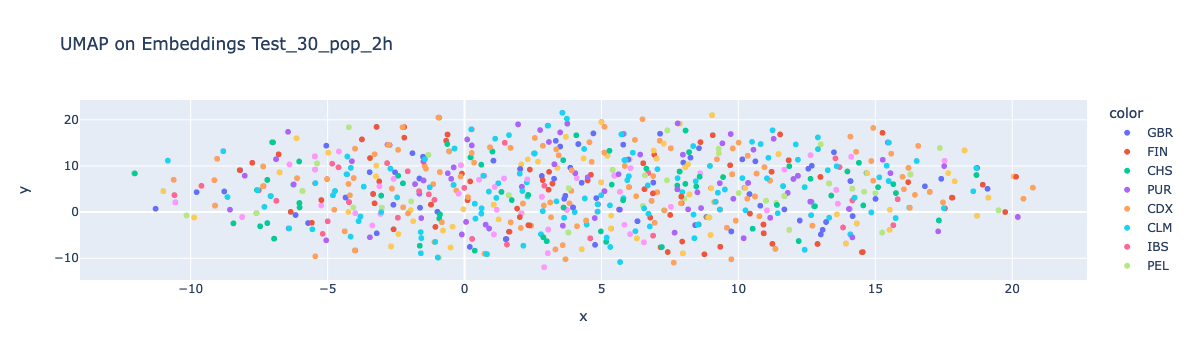

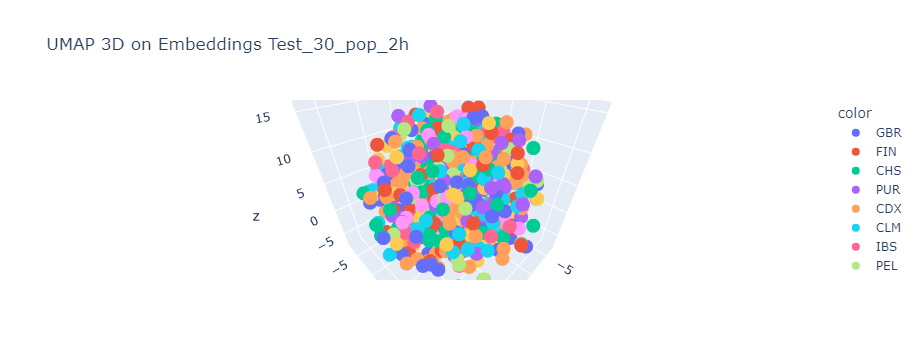

(2503, 120)


/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



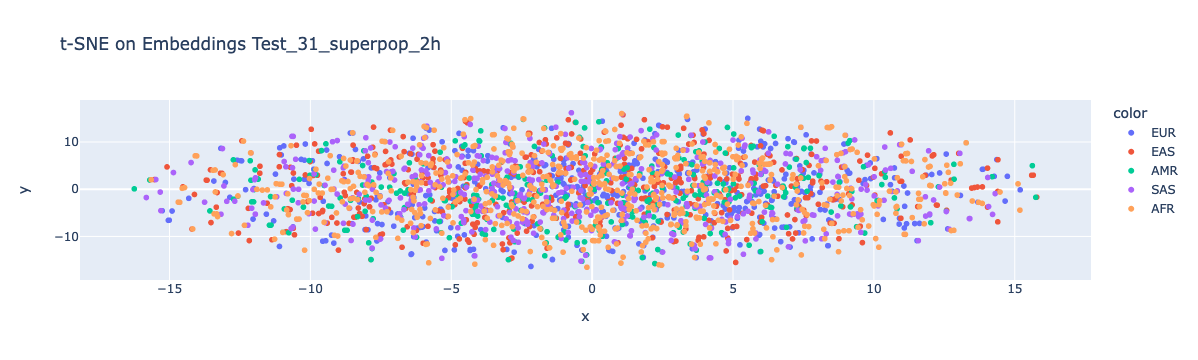

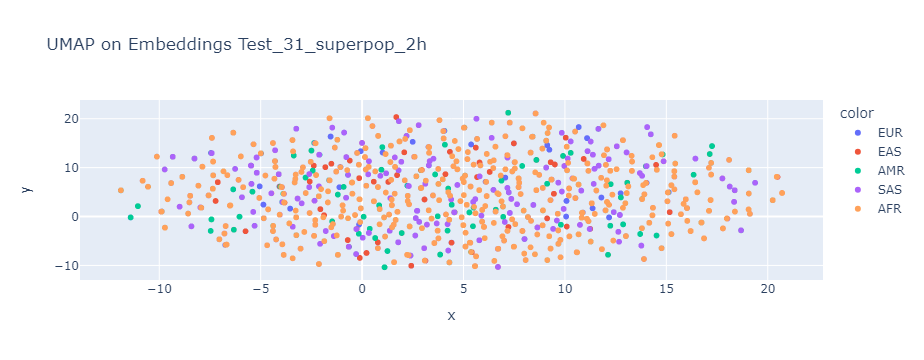

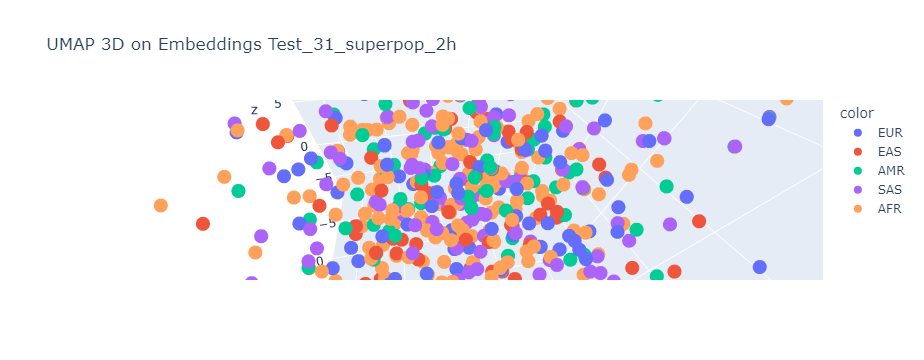

In [49]:
labelnames = [label_codes, label_superpops]

for i, model in enumerate(models):
    # Don't include padding_idx embedding weight
    embeddings = model.embed.weight.cpu().detach().numpy()[:-1, :]
    print(embeddings.shape)

    umap_params = {'min_dist': 0.0, 'n_neighbors': 2, 'target_weight': 1.0}
    umap_embeddings = UMAP(**umap_params, n_components=2, metric="cosine").fit_transform(embeddings)
    # umap_embeddings = UMAP(n_components=2, metric="cosine").fit_transform(embeddings)
    umap_3d_embeddings = UMAP(n_components=3, metric="cosine").fit_transform(embeddings)
    tsne_2d_embeddings = TSNE(n_components= 2, 
                                perplexity=30, 
                                learning_rate=200, 
                                early_exaggeration=12, 
                                n_iter=1000, 
                                init='pca').fit_transform(embeddings)
    
    fig = px.scatter(x=tsne_2d_embeddings[:, 0], y=tsne_2d_embeddings[:, 1], 
                     color=labelnames[i], 
                     # hover_name=inds,
                     title=f"t-SNE on Embeddings {model.get_name()}")
    fig.show()
    
    fig = px.scatter(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], 
                     color=labelnames[i], 
                     # hover_name=inds,
                     title=f"UMAP on Embeddings {model.get_name()}")
    fig.show()

    fig = px.scatter_3d(x=umap_3d_embeddings[:, 0], y=umap_3d_embeddings[:, 1], z=umap_3d_embeddings[:, 2],
                     color=labelnames[i], 
                     # hover_name=inds,
                     title=f"UMAP 3D on Embeddings {model.get_name()}")
    fig.show()

    # fig = px.scatter(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], 
    #                  color=input_codes, 
    #                  hover_name=inds,
    #                  title=f"UMAP on Embeddings {model.get_name()}")
    # fig.show()
    

## Attention Analysis

In [54]:
embed_size = 120

def get_attn_weights(model, x, mask, normalize=False):
    model.train(False)
    model.eval()

    # Pass given data through the model
    out = model(x, mask)
    # Get attention weights
    att_weights = [activation[f"el{i}_attn"][1].cpu().numpy() for i in range(1, 4)]

    # Normalize weights to [0, 1]
    if normalize:
        for i, a in enumerate(att_weights):
            min, max = np.min(a), np.max(a)
            att_weights[i] = ((a - min) / (max - min))

    return att_weights

def get_attn_for_inds(model, inds: list[int], y, y_labels, normalize=False):
    x, _, mask = make_data(inds, y)
    attn_weights = get_attn_weights(model, x, mask, normalize=normalize)
    tokens = np.array(y_labels)[np.squeeze(x)]

    return attn_weights, tokens

def get_QKV_weights(model, embed_dim=embed_size):
    q_w, k_w, v_w = torch.split(model.encoder.layers[0].self_attn.in_proj_weight, [embed_dim, embed_dim, embed_dim])
    q_b, k_b, v_b = torch.split(model.encoder.layers[0].self_attn.in_proj_bias, [embed_dim, embed_dim, embed_dim])
    q_w = q_w.T
    k_w = k_w.T
    v_w = v_w.T

    return (q_w, q_b), (k_w, k_b), (v_w, v_b)

def viz_avg_attn(attn_weights, tokens):
    avg = np.stack(attn_weights).squeeze().mean(axis=((0, 1) if attn_weights[0].shape[1] > 1 else 0))
    names = [x + str(i) for i, x in enumerate(tokens)]
    fig = px.imshow(avg, x=names, y=names)
    fig.show()

In [58]:
afr_inds = [940, 880, 980]
sasian_inds = [537, 961, 959, 536, 1001]

inds = afr_inds + sasian_inds

for model in models:
    attn_weights, tokens = get_attn_for_inds(model, inds, input_superpop)
    print(model.get_name())
    head_view([torch.tensor(a) for a in attn_weights], tokens)
    model_view([torch.tensor(a) for a in attn_weights], tokens)

Test_28_t_f_1h


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test_29_t_f_2h


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test_30_pop_2h ['AFR' 'AFR' 'AFR' 'SAS' 'SAS' 'SAS' 'SAS' 'SAS']


<IPython.core.display.Javascript object>

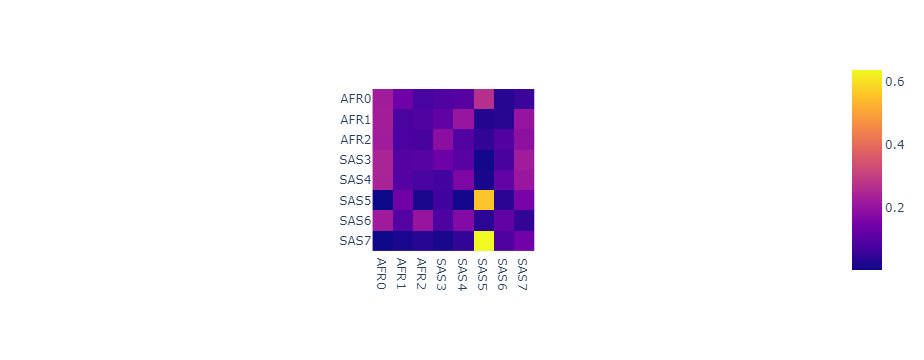

Test_31_superpop_2h ['AFR' 'AFR' 'AFR' 'SAS' 'SAS' 'SAS' 'SAS' 'SAS']


<IPython.core.display.Javascript object>

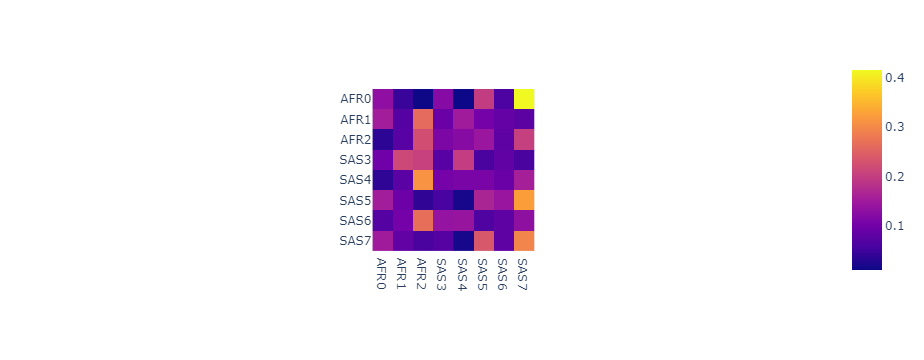

Test_30_pop_2h ['AFR' 'AFR' 'AFR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR']


<IPython.core.display.Javascript object>

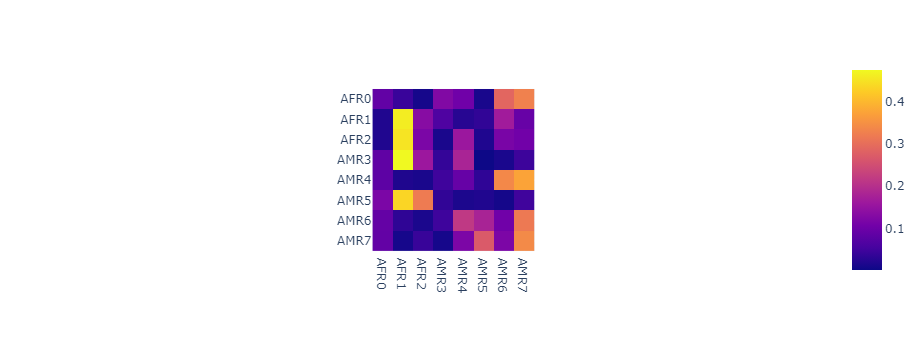

Test_31_superpop_2h ['AFR' 'AFR' 'AFR' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR']


<IPython.core.display.Javascript object>

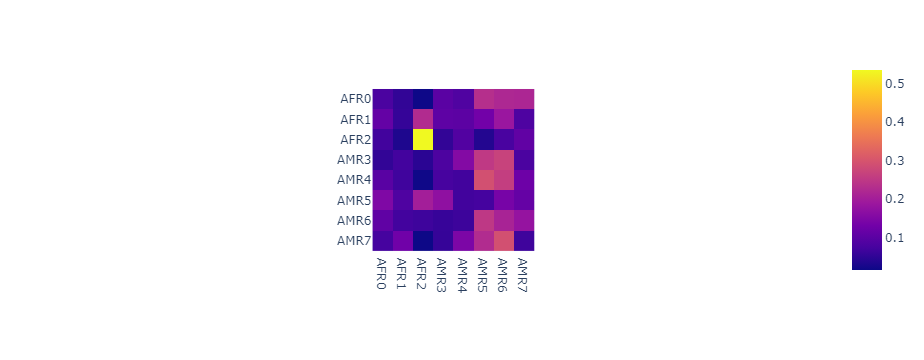

Test_30_pop_2h ['AFR' 'AFR' 'AFR' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

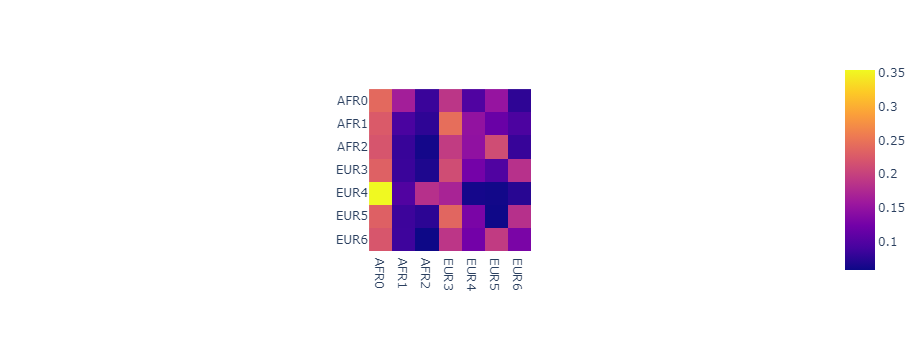

Test_31_superpop_2h ['AFR' 'AFR' 'AFR' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

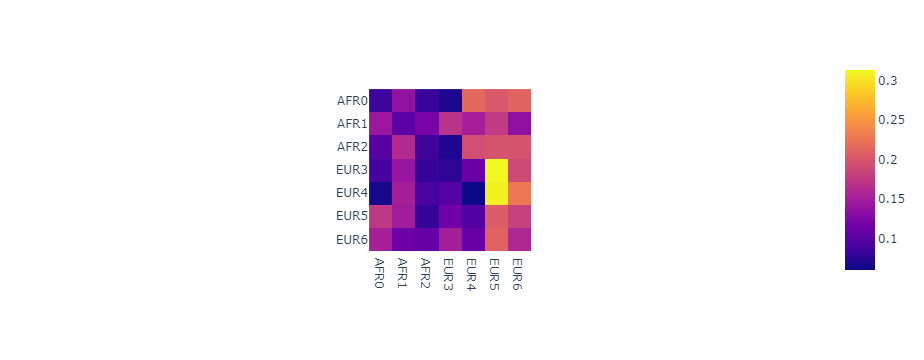

Test_30_pop_2h ['AFR' 'AFR' 'AFR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

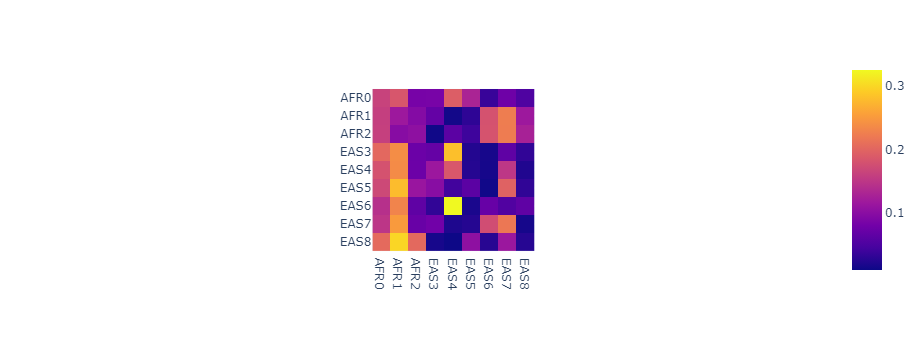

Test_31_superpop_2h ['AFR' 'AFR' 'AFR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

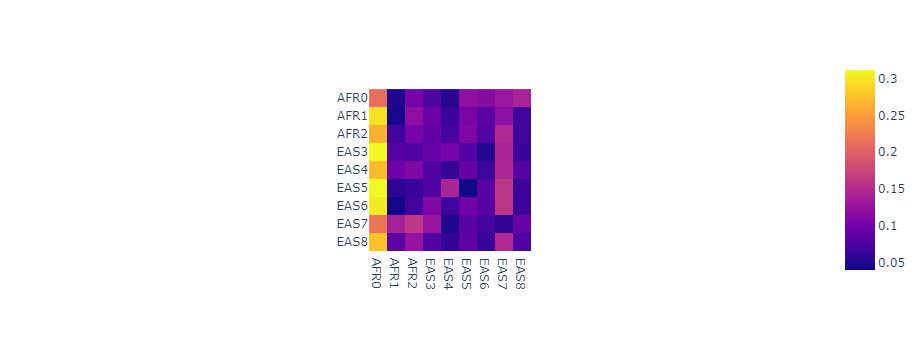

Test_30_pop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR']


<IPython.core.display.Javascript object>

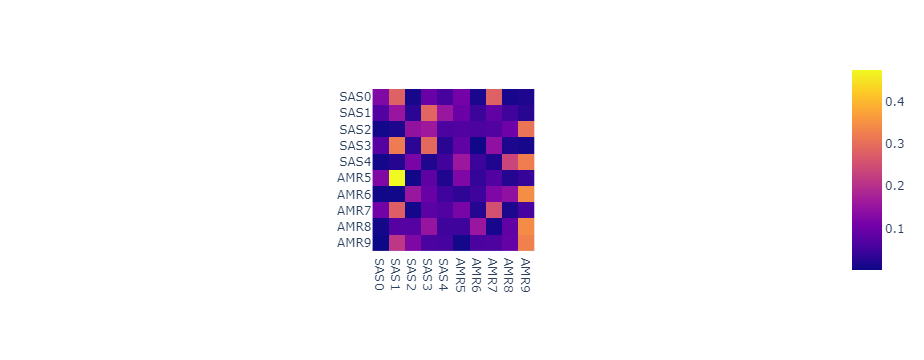

Test_31_superpop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'AMR' 'AMR' 'AMR' 'AMR' 'AMR']


<IPython.core.display.Javascript object>

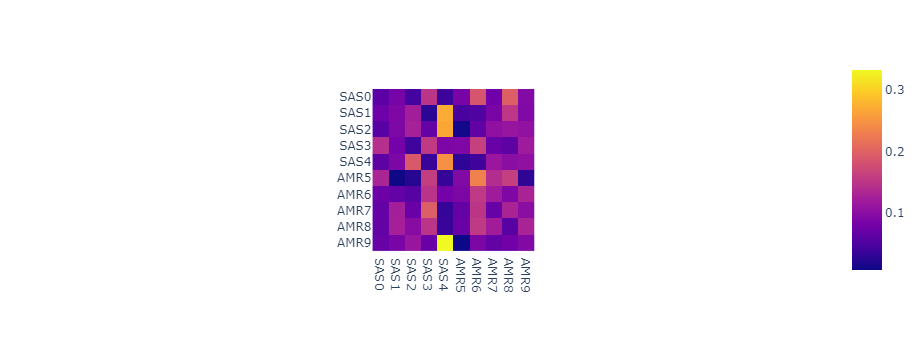

Test_30_pop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

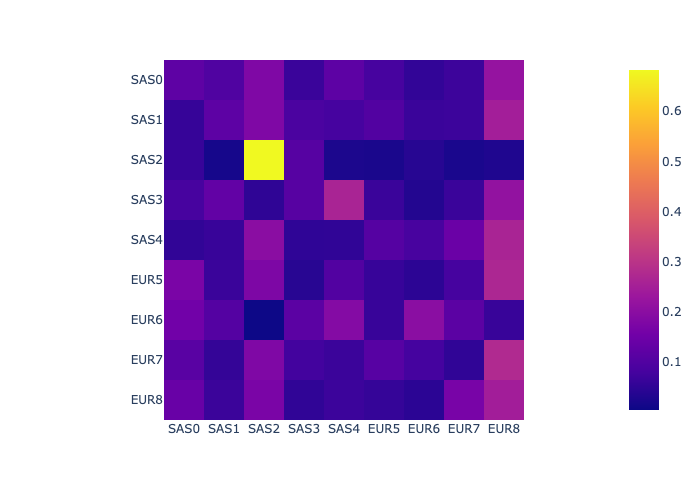

Test_31_superpop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

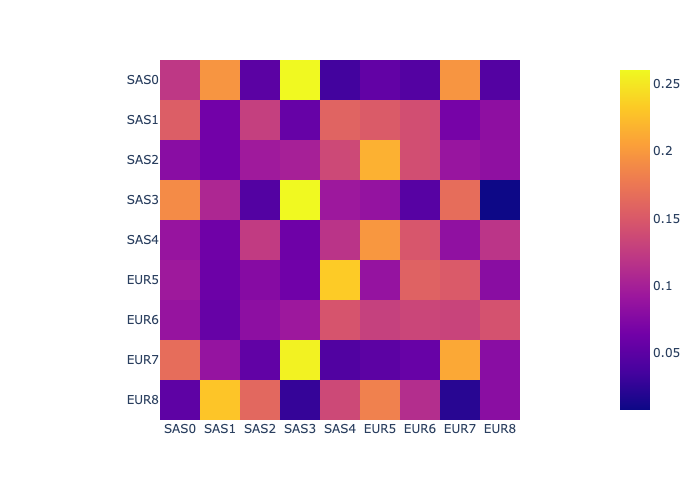

Test_30_pop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

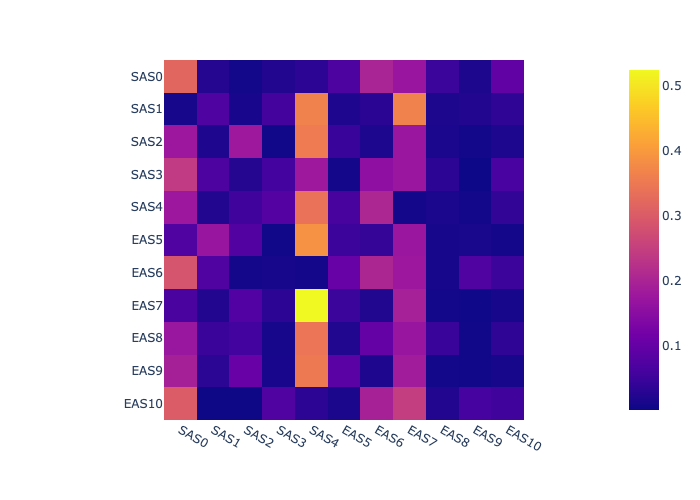

Test_31_superpop_2h ['SAS' 'SAS' 'SAS' 'SAS' 'SAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

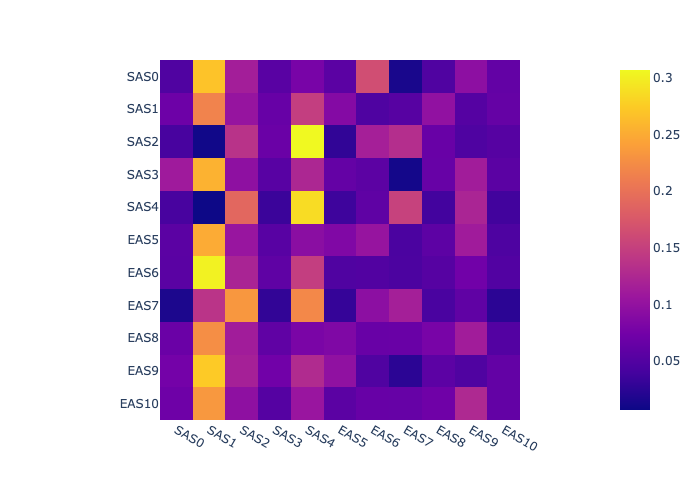

Test_30_pop_2h ['AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

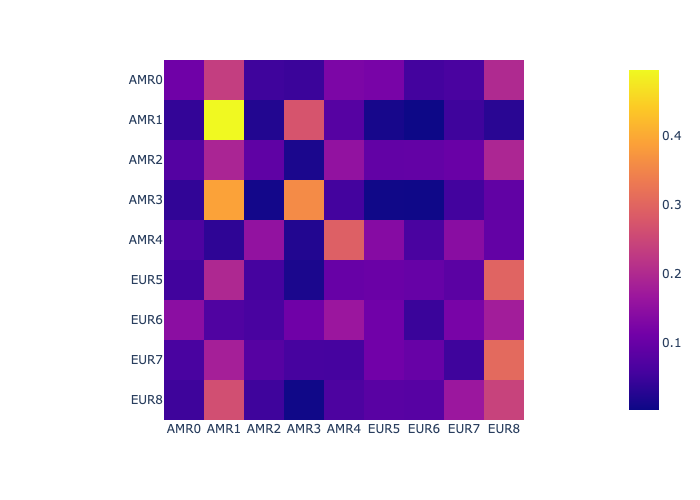

Test_31_superpop_2h ['AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EUR' 'EUR' 'EUR' 'EUR']


<IPython.core.display.Javascript object>

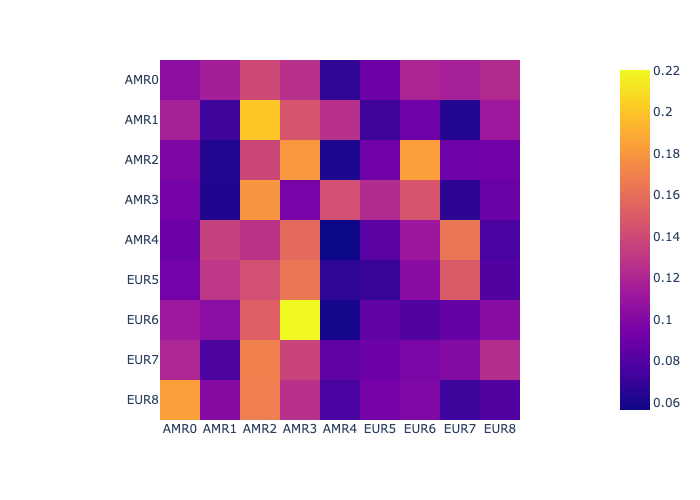

Test_30_pop_2h ['AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

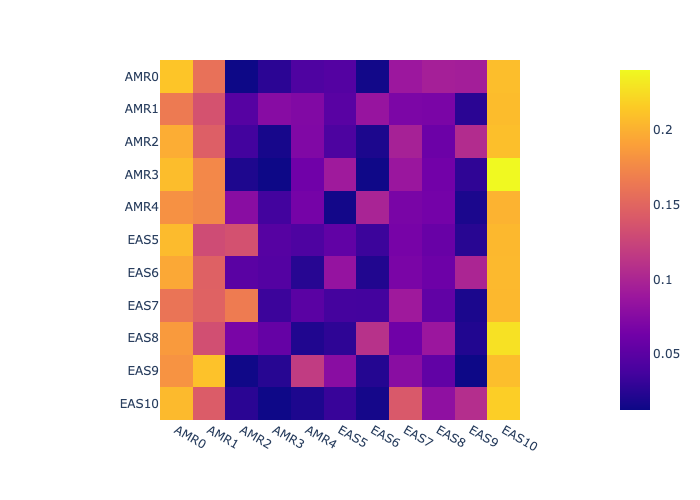

Test_31_superpop_2h ['AMR' 'AMR' 'AMR' 'AMR' 'AMR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

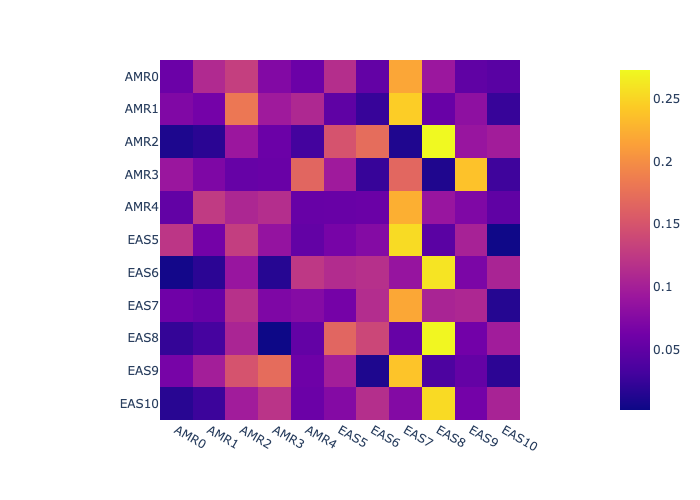

Test_30_pop_2h ['EUR' 'EUR' 'EUR' 'EUR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

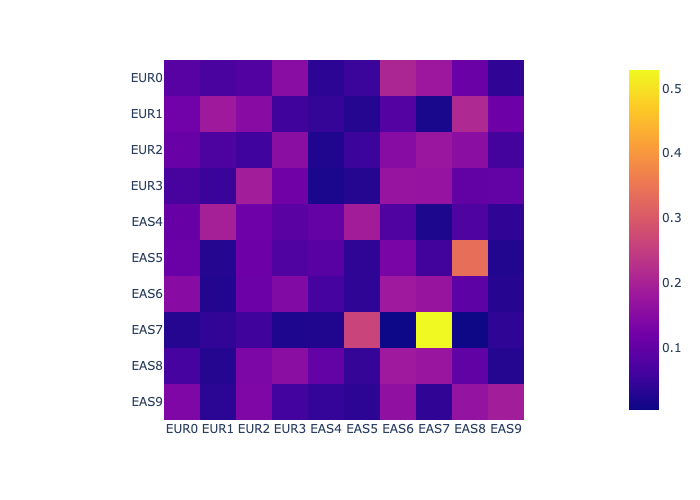

Test_31_superpop_2h ['EUR' 'EUR' 'EUR' 'EUR' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS' 'EAS']


<IPython.core.display.Javascript object>

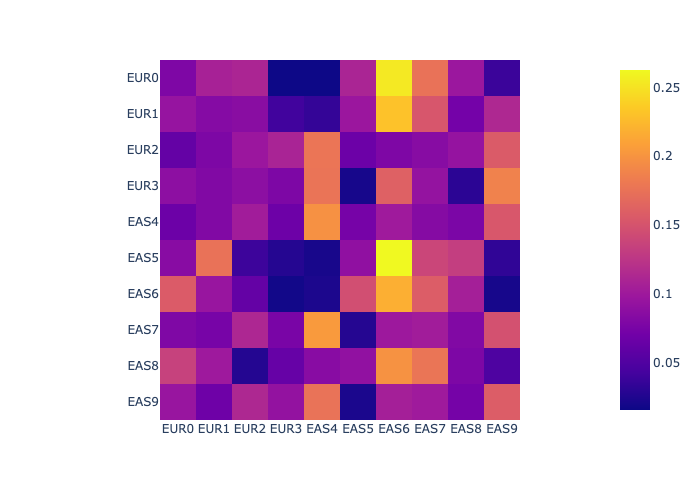

In [55]:
afr_inds = [940, 880, 980]
sasian_inds = [537, 961, 959, 536, 1001]
amer_clust_inds = [360, 300, 420, 340, 400]
euro_clust_inds = [140, 120, 20, 60]
easian_clust_inds = [800, 760, 900, 660, 220, 540]


# Do all possible combinations of 2 nationalities
all_clusts = [afr_inds, sasian_inds, amer_clust_inds, euro_clust_inds, easian_clust_inds]
for c1, c2 in itertools.combinations(all_clusts, 2):
    inds = c1 + c2
    for model in models:
        attn_weights, tokens = get_attn_for_inds(model, inds, y_ints, label_superpops)
        print(model.get_name(), tokens)
        head_view([torch.tensor(a) for a in attn_weights], tokens)
        viz_avg_attn(attn_weights, tokens)
        # model_view([torch.tensor(a) for a in attn_weights], tokens)

In [57]:
model.encoder.layers[0].self_attn.in_proj_weight.shape

torch.Size([360, 120])

In [56]:
(q_w, q_b), (k_w, k_b), (v_w, v_b) = get_QKV_weights(models[0])
[print(x.shape) for x in [q_w, q_b, k_w, k_b, v_w, v_b]]

torch.Size([120, 120])
torch.Size([120])
torch.Size([120, 120])
torch.Size([120])
torch.Size([120, 120])
torch.Size([120])


[None, None, None, None, None, None]

## Accuracy Scores

tensor([[10, 10, 10]]) torch.Size([1, 3])
Accuracy: 100.00%


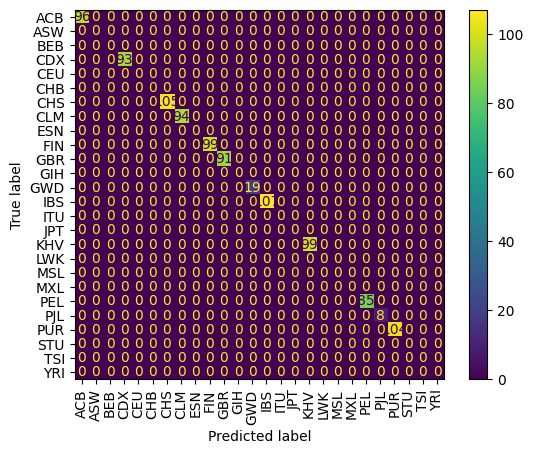

1.0

In [62]:
def get_scores(model, data_x, mask):
    out = model(data_x, mask).cpu().detach().numpy().squeeze().transpose()
    return np.argmax(out, axis=1)

def get_accuracy_cm(y_true, y_pred, labels):
    y_pred = y_pred.squeeze()
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2%}")
    conf = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cm_disp = ConfusionMatrixDisplay(conf, display_labels=labels)
    cm_disp.plot()
    plt.xticks(rotation=90)
    plt.show()
    return acc

# Example
data_x, data_y, mask = make_data([1, 2, 4], y_ints)
print(data_y, data_x.shape)
get_scores(models[0], data_x, mask)



data_x, data_y, mask = make_data(list(range(1000)), y_ints)
# y_true_labels = label_codes[:1000].tolist()
# print(y_true_labels)

y_pred = get_scores(models[0], data_x, mask)
get_accuracy_cm(data_y.numpy().squeeze(), y_pred, king_popcodes["1"].tolist())




In [63]:
y_pred, y_true, x_label = np.array([]), np.array([]), np.array([])
model = models[0]


for x, y, mask in test_dataloader:
    y_true = np.append(y_true, y.numpy().squeeze())
    x_label = np.append(x_label, x.numpy().squeeze())

    y_pred_out = get_scores(model, x, mask)
    y_pred = np.append(y_pred, y_pred_out)
    
print(y_pred.shape, y_true.shape, x_label.shape)

python3.10(35692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


(205062,) (205062,) (205062,)


Accuracy: 100.00%


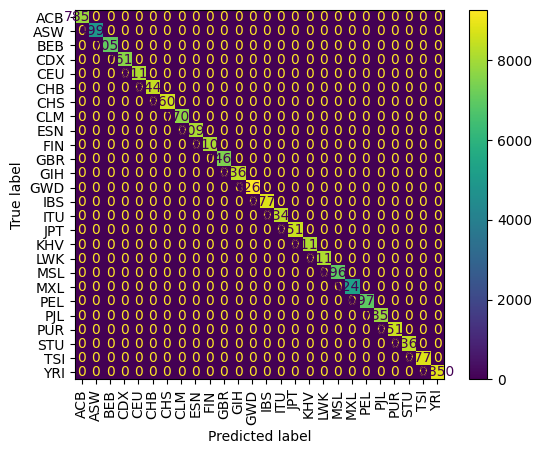

1.0

In [64]:
get_accuracy_cm(y_true, y_pred, king_popcodes["1"].tolist())

In [65]:
y_pred, y_true, x_label = np.array([]), np.array([]), np.array([])
model = models[1]

for x, y, mask in test_superpop_dataloader:
    y_true = np.append(y_true, y.numpy().squeeze())
    x_label = np.append(x_label, x.numpy().squeeze())

    y_pred_out = get_scores(model, x, mask)
    y_pred = np.append(y_pred, y_pred_out)
    
print(y_pred.shape, y_true.shape, x_label.shape)

python3.10(35697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


(205062,) (205062,) (205062,)


Accuracy: 100.00%


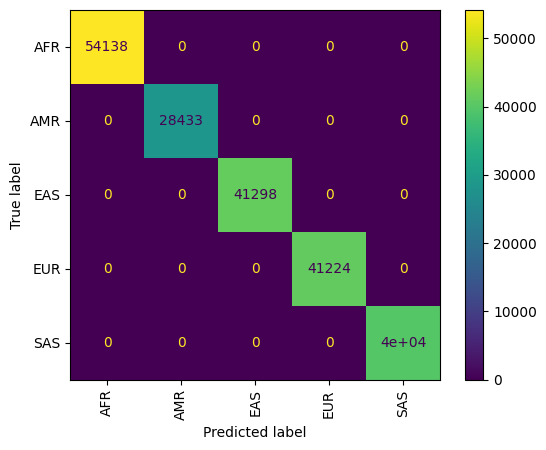

1.0

In [72]:
get_accuracy_cm(y_true, y_pred, label_superpops.astype("category").cat.categories.tolist())